In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import joblib

2025-11-19 08:49:40.381410: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 08:49:40.966245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 08:49:43.362976: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
train_data = pd.read_csv('customer_churn_dataset-training-master.csv')
test_data = pd.read_csv('customer_churn_dataset-testing-master.csv')
data  = pd.concat([train_data, test_data], ignore_index=True)

data.isna().sum()
data.dropna(inplace=True)



In [3]:
data.drop(['CustomerID'], axis=1, inplace=True)

In [4]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:

unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


{np.float64(0.0): np.int64(224714), np.float64(1.0): np.int64(280492)}


In [7]:
# label encoding gender column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train[:,1] = le.fit_transform(X_train[:, 1])
X_test[:, 1] = le.fit_transform(X_test[:, 1])

In [8]:
print(X_train)
print(X_test)

[[41.0 1 28.0 ... 'Quarterly' 502.45 2.0]
 [43.0 0 46.0 ... 'Quarterly' 517.58 11.0]
 [32.0 1 27.0 ... 'Quarterly' 798.05 16.0]
 ...
 [41.0 1 47.0 ... 'Quarterly' 908.38 16.0]
 [34.0 0 38.0 ... 'Quarterly' 853.79 11.0]
 [32.0 0 12.0 ... 'Quarterly' 149.0 2.0]]
[[41.0 1 60.0 ... 'Monthly' 409.0 18.0]
 [25.0 1 6.0 ... 'Annual' 780.31 9.0]
 [20.0 0 28.0 ... 'Annual' 230.47 10.0]
 ...
 [54.0 1 59.0 ... 'Annual' 699.0 14.0]
 [21.0 0 47.0 ... 'Quarterly' 853.0 20.0]
 [20.0 0 48.0 ... 'Quarterly' 476.0 28.0]]


In [9]:
# one hot encoding categorical data
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [ 6, 7])], remainder='passthrough')
X_train = np.array(ct.fit_transform(X_train))
X_test = np.array(ct.transform(X_test))

In [10]:
print(X_train)
print(y_train)

[[0.0 1.0 0.0 ... 6.0 502.45 2.0]
 [0.0 1.0 0.0 ... 0.0 517.58 11.0]
 [1.0 0.0 0.0 ... 2.0 798.05 16.0]
 ...
 [0.0 1.0 0.0 ... 4.0 908.38 16.0]
 [1.0 0.0 0.0 ... 3.0 853.79 11.0]
 [1.0 0.0 0.0 ... 26.0 149.0 2.0]]
[0. 0. 0. ... 0. 0. 1.]


In [11]:
print(X_test)
print(y_test)

[[0.0 0.0 1.0 ... 27.0 409.0 18.0]
 [0.0 1.0 0.0 ... 7.0 780.31 9.0]
 [1.0 0.0 0.0 ... 4.0 230.47 10.0]
 ...
 [0.0 1.0 0.0 ... 6.0 699.0 14.0]
 [0.0 0.0 1.0 ... 9.0 853.0 20.0]
 [0.0 0.0 1.0 ... 29.0 476.0 28.0]]
[1. 0. 1. ... 1. 1. 1.]


In [12]:
# Feature scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(sc, f)

In [14]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(
    n_estimators=20,
    criterion='entropy',
    random_state=0,
    class_weight='balanced'  # this recalculates balance per bootstrap sample
)
classifier.fit(X_train, y_train)

,n_estimators,20
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[[38577  6324]
 [  320 55821]]
Accuracy: 0.934245165376774


In [16]:
import pickle

with open("ct.pkl", "wb") as f:
    pickle.dump(ct, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(sc, f)

with open("le_gender.pkl", "wb") as f:
    pickle.dump(le, f)

In [17]:

joblib.dump(classifier, "classifier.pkl")

['classifier.pkl']

In [18]:

input = [65,'Male',8,4,2,23,'Basic','Annual',995,10]
input2 = [55,'Male',50,28,0,17,'Standard','Quarterly',449,3]
input = np.array(input2)
input = input.reshape(1, -1)
# Preprocess input
input[:, 1] = le.transform(input[:, 1])
input = ct.transform(input)
input = sc.transform(input)
prediction = classifier.predict(input)
print("Prediction for input2:", prediction)  # 0 or 1

Prediction for input2: [1.]


# confusion matrix

<Figure size 600x500 with 0 Axes>

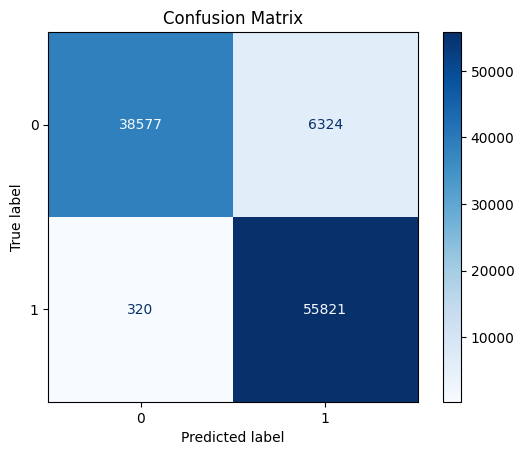

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
